In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import sys
from bmtool.util import util
from bmtk.simulator import bionet

MODEL_PATH = os.path.join('..', 'M1Focus')
sys.path.append(MODEL_PATH)
from build_input import get_populations, t_stop, t_start, on_time, off_time
import plot

TRIAL_NAME = "baseline_test_0"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

isbaseline = True

In [2]:
spike_file = os.path.join('..', 'Analysis', TRIAL_PATH, 'spikes.h5')
config_file = os.path.join(MODEL_PATH, 'config.json')

pop_color = {'CP': 'blue', 'CS': 'green', 'FSI': 'red', 'LTS': 'purple'}
pop_names = list(pop_color.keys())

### Spike Raster

In [3]:
conf = bionet.Config.from_json(config_file)
t_stop = conf['run']['tstop'] / 1000

nodes = util.load_nodes_from_config(config_file)
network_name = 'cortex'
cortex_df = nodes[network_name]

with h5py.File(spike_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })
    spikes_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

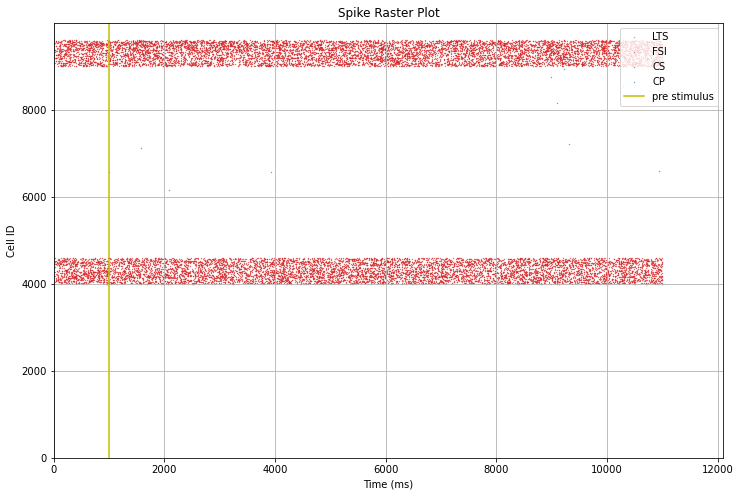

In [4]:
spikes_df['pop_name'] = cortex_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, ax=ax)
plt.axvline(t_start * 1000, color='y', label='pre stimulus')
plt.legend(loc='upper right')
plt.xlim([0, 1.1 * spikes_df['timestamps'].max()])
plt.ylim([cortex_df.index.min(), cortex_df.index.max()])
plt.show()

### Firing Rate

In [5]:
frs = plot.firing_rate(spikes_df, num_cells=len(cortex_df), time_windows=(0., t_stop))
Cortex_nodes = get_populations(cortex_df, pop_names, only_id=True)
pop_fr = {p: frs[nid] for p, nid in Cortex_nodes.items()}

print('Firing rate: mean/(std)')
for p, fr in pop_fr.items():
    print(f'{p}: {fr.mean():.4g}/({fr.std():.4g})')

Firing rate: mean/(std)
CP: 0.0002045/(0.004307)
CS: 2.273e-05/(0.001437)
FSI: 1.343/(1.104)
LTS: 0/(0)


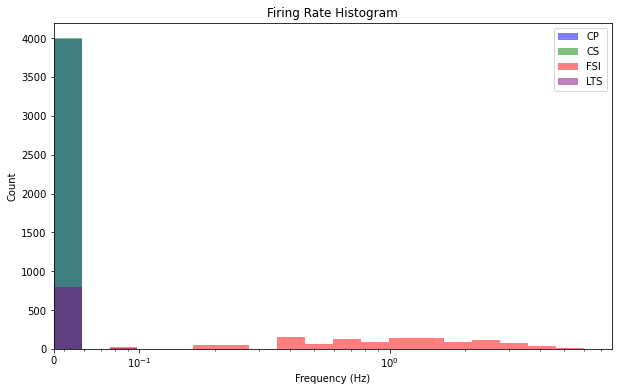

In [6]:
min_fr = 0.5 / plot.total_duration((0., t_stop))
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.firing_rate_histogram(pop_fr, pop_color, bins=20, min_fr=min_fr,
                      logscale=True, stacked=False, ax=ax)
plt.show()

### Calling plot functions directly

Plotting cortex spike raster


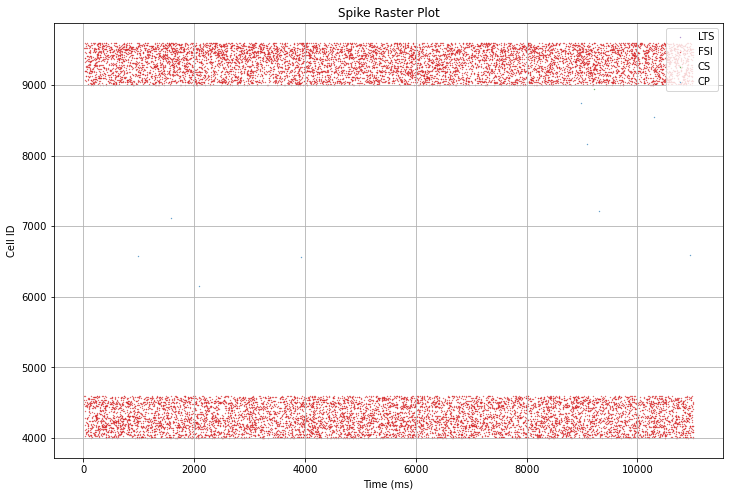

Firing rate: mean/(std)
CP: 0.0002045/(0.004307)
CS: 2.273e-05/(0.001437)
FSI: 1.343/(1.104)
LTS: 0/(0)
Plotting firing rates


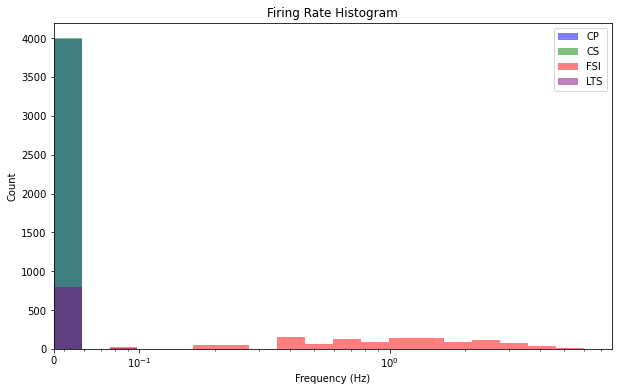

In [7]:
pop_spike = plot.plot(choose=1, spike_file=spike_file, config=config_file, figsize=(12, 8))
frs = plot.plot(choose=2, spike_file=spike_file, figsize=(10, 6))